# MUTAN: Multimodal Tucker Fusion for VQA

- https://github.com/Cadene/vqa.pytorch
<img src="./imgs/mutan_concept.jpg" width="800">

- 이미지, 텍스트 정보를 어떻게 합할 것인가? → Bilinear model이 효과적
  - encode fully-parametrized bilinear interaction
  - 그런데 fully-parametrized bilinear interaction은 차원이 너무 커짐
- Tucker decomposition을 활용하여 Image, Question의 bilinear interaction을 효율적으로 표현
- Multimodal fusion scheme based on bilinear interactions between modalities
- Contribution
  - Tucker decomposition은 MCB, MLB 등의 다른 bilinear model을 더 일반화한 방법
  - Sparsity constraint를 활용해 모델 파라미터 수를 조절 가능
  - State-of-the-art on the most widely used [VQA dataset](http://visualqa.org/)

## Model Architecture
![model](./imgs/mutan_model.jpg)

Bilinear interactions between the vectors $\mathbf{q}$ and $\mathbf{v}$ is
\begin{equation} \mathbf{y} = \mathcal{T} \, \small{\times_1} \, \mathbf{q} \, \small{\times_2} \, \mathbf{v}\end{equation}
where $\scriptsize{\mathcal{T} \in \mathbb{R}^{d_q \times d_v \times |\mathcal{A}|}}$ and $\scriptsize{\times_k}$ is k-mode product.  
여기서 $\scriptsize{\mathcal{T}}$를 그대로 사용하면 파라미터 수가 매우 많아지기 때문에 Tucker decomposition으로 factorize

(참고) k-mode product  
The k-mode product of a tensor $\scriptsize{X \in \mathbb{R}^{I_1 \times I_2 \times \dots \times I_n}}$ with a matrix $\scriptsize{A \in \mathbb{R}^{J \times I_k}}$ is  

\begin{aligned} Y &= X \, \small{\times_k} \, A  \\
\small{\text{where }} \, y_{i_1 \dots i_{k-1}ji_{k+1} \dots i_n} &= \sum_{i_k = 1}^{I_k} x_{i_1 \dots i_n} a_{ji_k}  \end{aligned}

The size of resulting tensor $\scriptsize{Y}$ is $\scriptsize{I_1 \times \dots I_{K-1} \times J \times I_{k+1} \dots \times I_n}$ .
- Property
\begin{aligned} X \, \small{\times_m} \, A \, \small{\times_n} \, B &= X \, \small{\times_n} \, B \, \small{\times_m} \, A \, \scriptsize{\text{ where }} \small{m \neq n} \\
X \, \small{\times_n} \, A \, \small{\times_n} \, B &= X \, \small{\times_n} \, (BA) \quad (\scriptsize{\text{in general }} \small{\neq X \, \small{\times_n} \, B \, \small{\times_n} \, A})\end{aligned}

## Tucker decomposition
<img src="./imgs/tucker.jpg" width="300">  
 
- Higher order SVD
- Higher order orthogonal iteration

우리 문제에서는, 
\begin{equation} \mathcal{T} = \mathcal{T_c} \,\, \small{\times_1} \, W_q \,\, \small{\times_2} \, W_v \,\, \small{\times_3} \, W_o\end{equation}
where $\scriptsize{W_q \in \mathbb{R}^{d_q \times t_q}}$, $\scriptsize{W_v \in \mathbb{R}^{d_v \times t_v}}$, $\scriptsize{W_o \in \mathbb{R}^{|\mathcal{A}| \times t_o}}$, $\scriptsize{\mathcal{T}_c \in \mathbb{R}^{t_q \times t_v \times t_o}}$.  
\begin{aligned} \mathbf{y} &= \mathcal{T} \,\, \small{\times_1} \,\, \mathbf{q} \,\, \small{\times_2} \,\, \mathbf{v} \\
&= \mathcal{T}_c \,\, \small{\times_1} \,\, (\mathbf{q}^T W_q) \,\, \small{\times_2} \,\, (\mathbf{v}^T W_v) \,\, \small{\times_3} \,\, W_o \end{aligned}

If we define $\,\scriptsize{\tilde{\mathbf{q}} := \mathbf{q}^T W_q} \in \mathbb{R}^{t_q}\,$  and  $\,\scriptsize{\tilde{\mathbf{v}} := \mathbf{v}^T W_v} \in \mathbb{R}^{t_v}\,$, then 
\begin{aligned} \mathbf{z} &:= \mathcal{T}_c \,\, \small{\times_1} \,\, \tilde{\mathbf{q}}  \,\, \small{\times_2} \,\, \tilde{\mathbf{v}} \in \mathbb{R}^{t_o} \\
\mathbf{y} &= \mathbf{z}^T W_o \in \mathbb{R}^{|\mathcal{A}|} \end{aligned}
This is strictly equivalent to encode a full bilinear interaction of projections of $\scriptsize{\mathbf{q}}$ and $\scriptsize{\mathbf{v}}$ into a latent pair representation $\scriptsize{\mathbf{z}}$.  

- $\scriptsize{W_q}$, $\scriptsize{W_v}$는 질문과 이미지를 각각 $\scriptsize{t_q}$, $\scriptsize{t_v}$차원으로 project  
- $\scriptsize{\mathcal{T}_c}$는 질문과 이미지 간의 interaction을 $\scriptsize{t_o}$ 차원으로 project
- $\scriptsize{t_q}$, $\scriptsize{t_v}$ 차원 크기에 따라 모델의 question, image에 관한 complexity 반영

## Tensor Sparsity
- Interaction modeling에서는 expressivity와 complexity의 밸런스 필요  
- Slice matrices in $\scriptsize{\mathcal{T}_c}$에 sparsity constraint $\scriptsize{R}$ 적용  

\begin{aligned} \mathbf{z}[k] &= \tilde{\mathbf{q}}^T \, \mathcal{T}_c[:,:,k] \, \tilde{\mathbf{v}} \\
\mathcal{T}_c[:,:,k] &\approx \sum_{r=1}^{R} m_r^k \otimes {n_r^k}^T \, \small{\text{where }} \, m_r^k \in \mathbb{R}^{t_q}, n_r^k \in \mathbb{R}^{t_v} \\
\mathbf{z}[k] &= \sum_{r=1}^{R}(\tilde{\mathbf{q}}^T m_r^k) (\tilde{\mathbf{v}}^T n_r^k) \end{aligned}
If we define $\scriptsize{R}$ matrices $\scriptsize{M_r \in \mathbb{R}^{t_q \times t_o}}$, $\scriptsize{N_r \in \mathbb{R}^{t_v \times t_o}}$ such as $\scriptsize{M_r[:,k] = m_r^k}$, $\scriptsize{N_r[:,k] = n_r^k}$ for all k, then the structured sparsity on $\scriptsize{\mathcal{T}_c}$ can be written as 
\begin{aligned} \mathbf{z} &= \sum_{r=1}^R \mathbf{z}_r \\
\small{\text{where }} \, \mathbf{z}_r &= (\tilde{\mathbf{q}}^T M_r) * (\tilde{\mathbf{v}}^T N_r) \end{aligned}
- Interpretation

\begin{aligned} \mathbf{z}_r[k] &= (\tilde{\mathbf{q}} \small{\text{ similar to }} \normalsize{m_r^k}) \scriptsize{\text{ AND }} \normalsize( \tilde{\mathbf{v}} \small{\text{ similar to }} \normalsize n_r^k) \\
\mathbf{z}[k] &= \mathbf{z}_1[k] \, \scriptsize{\text{ OR }} \, \dots \, \scriptsize{\text{ OR }} \, \normalsize \mathbf{z}_R[k] \end{aligned}

## Model Setup
<!-- - Resize images to be of size (448, 448) -->
- Visual feature extractor
  - use ResNet152 (feature maps of size 14 x 14 x 2048)
  - Attention model: keep 14 x 14 tiling
  - Without attention: average of 14 x 14 vectors
- Question feature
  - GNMT encoder
  - cf. 기존 논문 : GRU initialized w/ pretrained Skip-thoughts model
- Train to predict the most common answer in the 10 annotated responses
- $\scriptsize{t_q = t_v = t_o = 360}$, $\scriptsize{R = 10}$
- $\scriptsize{|\mathcal{A}|}$ is fixed to the 2000 most frequent answers
- Use ADAM  

# Without Attention

In [1]:
import os
import time
import random
import numpy as np
from tqdm import tqdm
import bisect
import json
import logging
#logging.basicConfig(level=logging.INFO)

import mxnet as mx
from mxnet import nd, autograd, gluon
import mxnet.gluon as gluon
from mxnet.gluon import Parameter
from mxnet.gluon import nn
from mxnet.test_utils import download
import mxnet.ndarray as F
import mxnet.contrib.ndarray as C

mx.random.seed(1)
ctx = mx.cpu()

/Users/jsh/anaconda3/lib/python3.6/site-packages/urllib3/contrib/pyopenssl.py:46: DeprecationWarning: OpenSSL.rand is deprecated - you should use os.urandom instead
  import OpenSSL.SSL


In [21]:
# Some parameters we are going to use
batch_size = 512
compute_size  = batch_size
num_classes = 2000
gpus = 1

### Load Dataset
- Ref: http://gluon.mxnet.io/chapter08_computer-vision/visual-question-answer.html?highlight=block

In [22]:
# Download the dataset
dataset_files = {'train': ('train_question.npz','train_img.npz','train_ans.npz'),
                 'validation': ('val_question.npz','val_img.npz','val_ans.npz'),
                 'test':('test_question_id.npz','test_question.npz','test_img_id.npz','test_img.npz','atoi.json','test_question_txt.json')}

train_q, train_i, train_a = dataset_files['train']
val_q, val_i, val_a = dataset_files['validation']

url_format = 'https://apache-mxnet.s3-accelerate.amazonaws.com/gluon/dataset/VQA-notebook/{}'
if not os.path.exists(train_q):
    download(url_format.format(train_q), overwrite=True)
    download(url_format.format(train_i), overwrite=True)
    download(url_format.format(train_a), overwrite=True)
if not os.path.exists(val_q):
    download(url_format.format(val_q), overwrite=True)
    download(url_format.format(val_i), overwrite=True)
    download(url_format.format(val_a), overwrite=True)

In [101]:
# Data Iterator
class VQAtrainIter(mx.io.DataIter):
    def __init__(self, img, sentences, answer, batch_size, buckets=None, invalid_label=-1,
                 text_name='text', img_name = 'image', label_name='softmax_label', dtype='float32', layout='NTC'):
        super(VQAtrainIter, self).__init__()
        if not buckets:
            buckets = [i for i, j in enumerate(np.bincount([len(s) for s in sentences]))
                       if j >= batch_size]
        buckets.sort()

        ndiscard = 0
        self.data = [[] for _ in buckets]
        for i in range(len(sentences)):
            buck = bisect.bisect_left(buckets, len(sentences[i]))
            if buck == len(buckets):
                ndiscard += 1
                continue
            buff = np.full((buckets[buck],), invalid_label, dtype=dtype)
            buff[:len(sentences[i])] = sentences[i]
            self.data[buck].append(buff)

        self.data = [np.asarray(i, dtype=dtype) for i in self.data]
        self.answer = answer
        self.img = img
        print("WARNING: discarded %d sentences longer than the largest bucket."%ndiscard)

        self.batch_size = batch_size
        self.buckets = buckets
        self.text_name = text_name
        self.img_name = img_name
        self.label_name = label_name
        self.dtype = dtype
        self.invalid_label = invalid_label
        self.nd_text = []
        self.nd_img = []
        self.ndlabel = []
        self.major_axis = layout.find('N')
        self.default_bucket_key = max(buckets)

        if self.major_axis == 0:
            self.provide_data = [(text_name, (batch_size, self.default_bucket_key)),
                                 (img_name, (batch_size, self.default_bucket_key))]
            self.provide_label = [(label_name, (batch_size, self.default_bucket_key))]
        elif self.major_axis == 1:
            self.provide_data = [(text_name, (self.default_bucket_key, batch_size)),
                                 (img_name, (self.default_bucket_key, batch_size))]
            self.provide_label = [(label_name, (self.default_bucket_key, batch_size))]
        else:
            raise ValueError("Invalid layout %s: Must by NT (batch major) or TN (time major)")

        self.idx = []
        for i, buck in enumerate(self.data):
            self.idx.extend([(i, j) for j in range(0, len(buck) - batch_size + 1, batch_size)])
        self.curr_idx = 0

        self.reset()

    def reset(self):
        self.curr_idx = 0
        self.nd_text = []
        self.nd_img = []
        self.ndlabel = []
        for buck in self.data:
            label = np.empty_like(buck.shape[0])
            label = self.answer
            self.nd_text.append(mx.ndarray.array(buck, dtype=self.dtype))
            self.nd_img.append(mx.ndarray.array(self.img, dtype=self.dtype))
            self.ndlabel.append(mx.ndarray.array(label, dtype=self.dtype))

    def next(self):
        if self.curr_idx == len(self.idx):
            raise StopIteration
        i, j = self.idx[self.curr_idx]
        self.curr_idx += 1

        if self.major_axis == 1:
            img = self.nd_img[i][j:j + self.batch_size].T
            text = self.nd_text[i][j:j + self.batch_size].T
            label = self.ndlabel[i][j:j+self.batch_size]
        else:
            img = self.nd_img[i][j:j + self.batch_size]
            text = self.nd_text[i][j:j + self.batch_size]
            label = self.ndlabel[i][j:j+self.batch_size]

        data = [text, img]
        return mx.io.DataBatch(data, [label],
                         bucket_key=self.buckets[i],
                         provide_data=[(self.text_name, text.shape),(self.img_name, img.shape)],
                         provide_label=[(self.label_name, label.shape)])

In [102]:
layout = 'NT'
bucket = [1024]

train_question = np.load(train_q)['x']
val_question = np.load(val_q)['x']
train_ans = np.load(train_a)['x']
val_ans = np.load(val_a)['x']
train_img = np.load(train_i)['x']
val_img = np.load(val_i)['x']

print("Total training sample:",train_ans.shape[0])
print("Total validation sample:",val_ans.shape[0])

data_train  = VQAtrainIter(train_img, train_question, train_ans, batch_size, buckets = bucket,layout=layout)
data_eva = VQAtrainIter(val_img, val_question, val_ans, batch_size, buckets = bucket,layout=layout)

Total training sample: 21537
Total validation sample: 1044


### Network

In [103]:
class MutanNoAtt(gluon.Block):
    def __init__(self):
        super(MutanNoAtt, self).__init__()   
        with self.name_scope():
            self.drop_v = nn.Dropout(0.5)
            self.drop_q = nn.Dropout(0.5)
            
            self.Wq = nn.Dense(360, activation='tanh')
            self.Wv = nn.Dense(360, activation='tanh')

            self.Mv = nn.Sequential()
            for i in range(10):
                self.Mv.add(nn.Dense(360))
            self.Mq = nn.Sequential()
            for i in range(10):
                self.Mq.add(nn.Dense(360))
            
            self.drop_z = nn.Dropout(0.5)
            self.fc = nn.Dense(num_classes)

            
    def forward(self, x):
        q = x[0]
        v = x[1]
        batch_size = v.shape[0]

        til_q = self.drop_q(q)
        til_q= self.Wq(til_q)
        til_v = self.drop_v(v)
        til_v = self.Wv(til_v)
        
        z = F.zeros((batch_size, 360), ctx=ctx)
        for i in range(10):
            proj_til_q = self.Mq[i](til_q)
            proj_til_v = self.Mv[i](til_v)
            z = z + proj_til_q * proj_til_v

        z = self.drop_z(z)
        output = self.fc(z)
        return output

In [155]:
net = MutanNoAtt()
net.collect_params().initialize(mx.init.Xavier(), ctx=ctx)

In [105]:
print(net)

MutanNoAtt(
  (drop_v): Dropout(p = 0.5)
  (drop_q): Dropout(p = 0.5)
  (Wq): Dense(None -> 360, Activation(tanh))
  (Wv): Dense(None -> 360, Activation(tanh))
  (Mv): Sequential(
    (0): Dense(None -> 360, linear)
    (1): Dense(None -> 360, linear)
    (2): Dense(None -> 360, linear)
    (3): Dense(None -> 360, linear)
    (4): Dense(None -> 360, linear)
    (5): Dense(None -> 360, linear)
    (6): Dense(None -> 360, linear)
    (7): Dense(None -> 360, linear)
    (8): Dense(None -> 360, linear)
    (9): Dense(None -> 360, linear)
  )
  (Mq): Sequential(
    (0): Dense(None -> 360, linear)
    (1): Dense(None -> 360, linear)
    (2): Dense(None -> 360, linear)
    (3): Dense(None -> 360, linear)
    (4): Dense(None -> 360, linear)
    (5): Dense(None -> 360, linear)
    (6): Dense(None -> 360, linear)
    (7): Dense(None -> 360, linear)
    (8): Dense(None -> 360, linear)
    (9): Dense(None -> 360, linear)
  )
  (drop_z): Dropout(p = 0.5)
  (fc): Dense(None -> 2000, linear)
)


In [157]:
# LOSS & METRIC
loss = gluon.loss.SoftmaxCrossEntropyLoss()

metric = mx.metric.Accuracy()

def evaluate_accuracy(data_iterator, net):
    numerator = 0.
    denominator = 0.

    data_iterator.reset()
    for i, batch in enumerate(data_iterator):
        with autograd.record():
            data1 = batch.data[0].as_in_context(ctx)
            data2 = batch.data[1].as_in_context(ctx)
            data = [data1,data2]
            label = batch.label[0].as_in_context(ctx)
            output = net(data)

        metric.update([label], [output])
    return metric.get()[1]

In [158]:
trainer = gluon.Trainer(net.collect_params(), 'adam', {'learning_rate': 0.0001})

In [159]:
epochs = 100
moving_loss = 0.
best_eva = 0
for e in range(epochs):
    data_train.reset()
    for i, batch in enumerate(data_train):
        data1 = batch.data[0].as_in_context(ctx)
        data2 = batch.data[1].as_in_context(ctx)
        data = [data1,data2]
        label = batch.label[0].as_in_context(ctx)
        with autograd.record():
            output = net(data)
            cross_entropy = loss(output, label)
            cross_entropy.backward()
        trainer.step(data[0].shape[0])

        ##########################
        #  Keep a moving average of the losses
        ##########################
        if i == 0:
            moving_loss = np.mean(cross_entropy.asnumpy()[0])
        else:
            moving_loss = .99 * moving_loss + .01 * np.mean(cross_entropy.asnumpy()[0])
    eva_accuracy = evaluate_accuracy(data_eva, net)
    train_accuracy = evaluate_accuracy(data_train, net)
    print("Epoch %s. Loss: %.5f, Train_acc %.5f, Eval_acc %.5f" % (e, moving_loss, train_accuracy, eva_accuracy))

Epoch 0. Loss: 6.47310750984, Train_acc 0.252796519886, Eval_acc 0.2607421875
Epoch 1. Loss: 3.9276278616, Train_acc 0.269153941761, Eval_acc 0.253736413043
Epoch 2. Loss: 2.53433336044, Train_acc 0.279015743371, Eval_acc 0.268988715278
Epoch 3. Loss: 3.31506827758, Train_acc 0.286021839489, Eval_acc 0.279121968284
Epoch 4. Loss: 1.93300294897, Train_acc 0.291184303977, Eval_acc 0.286286429073
Epoch 5. Loss: 1.2653653638, Train_acc 0.295669093277, Eval_acc 0.291165188626
Epoch 6. Loss: 2.17522404904, Train_acc 0.300527597403, Eval_acc 0.295634104793
Epoch 7. Loss: 1.7483886643, Train_acc 0.304049405185, Eval_acc 0.300655241935
Epoch 8. Loss: 1.6327262924, Train_acc 0.308001893939, Eval_acc 0.304229563912
Epoch 9. Loss: 1.57852757177, Train_acc 0.311834161932, Eval_acc 0.308088293028
Epoch 10. Loss: 2.03210647795, Train_acc 0.315187564566, Eval_acc 0.311894619627
Epoch 11. Loss: 2.29145200224, Train_acc 0.318729285038, Eval_acc 0.31528903035
Epoch 12. Loss: 1.12596724418, Train_acc 0.32

In [160]:
#filename = 'mutanNoatt100.params'
#net.save_params(filename)
#net.load_params(filename, ctx=ctx)

### Test

In [161]:
test = True
if test:
    test_q_id, test_q, test_i_id, test_i, atoi,text = dataset_files['test']

if test and not os.path.exists(test_q):
    download(url_format.format(test_q_id),overwrite=True)
    download(url_format.format(test_q),overwrite=True)
    download(url_format.format(test_i_id),overwrite=True)
    download(url_format.format(test_i),overwrite=True)
    download(url_format.format(atoi),overwrite=True)
    download(url_format.format(text),overwrite=True)

if test:
    test_question = np.load("test_question.npz")['x']
    test_img = np.load("test_img.npz")['x']
    test_question_id = np.load("test_question_id.npz")['x']
    test_img_id = np.load("test_img_id.npz")['x']

In [162]:
data_test = VQAtrainIter(test_img, test_question, np.zeros((test_img.shape[0],1)), 10, buckets = bucket,layout=layout)
for i, batch in enumerate(data_test):
    with autograd.record():
        data1 = batch.data[0].as_in_context(ctx)
        data2 = batch.data[1].as_in_context(ctx)
        data = [data1,data2]
        #label = batch.label[0].as_in_context(ctx)
        #label_one_hot = nd.one_hot(label, 10)
        output = net(data)
output = np.argmax(output.asnumpy(), axis = 1)

In [167]:
idx = np.random.randint(10)
print(idx)
question = json.load(open(text))
print("Question:", question[idx])

9
Question: Is the bird looking at the camera?


In [168]:
for i in range(10):
    image_name = 'COCO_test2015_' + str(int(test_img_id[i])).zfill(12)+'.jpg'
    download(url_format.format('test_images/'+image_name),overwrite=True)

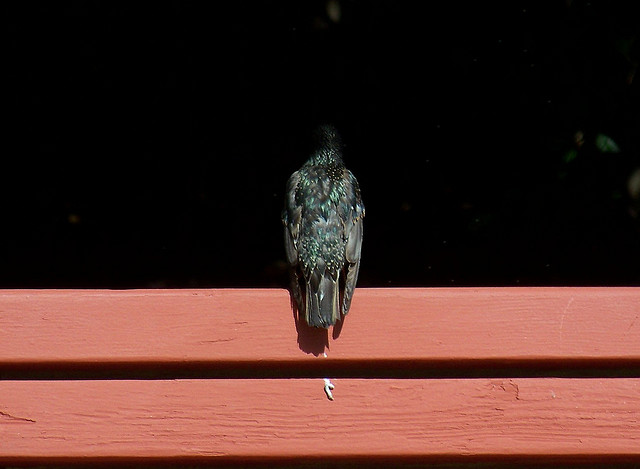

In [169]:
image_name = 'COCO_test2015_' + str(int(test_img_id[idx])).zfill(12)+'.jpg'
if not os.path.exists(image_name):
    logging.info('Downloading training dataset.')
    download(url_format.format('test_images/'+image_name),overwrite=True)

from IPython.display import Image
Image(filename=image_name)

In [170]:
dataset = json.load(open('atoi.json'))
ans = dataset['ix_to_ans'][str(output[idx]+1)]
print("Answer:", ans)

Answer: yes


# With Attention

<img src="./imgs/mutan_arch.jpg" width="500"></img>